#First time using a GAN, let's try to understand it.
Done by following the instructions in:
https://realpython.com/generative-adversarial-networks/

(For future reference, this example we be about two dimensional samples)


Import everything:

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

Now we set a seed to be able to replicate the experiment:

In [ ]:
torch.manual_seed(111)

And set up the training data, then plot it and make a data loader with pyTorch using the training set.

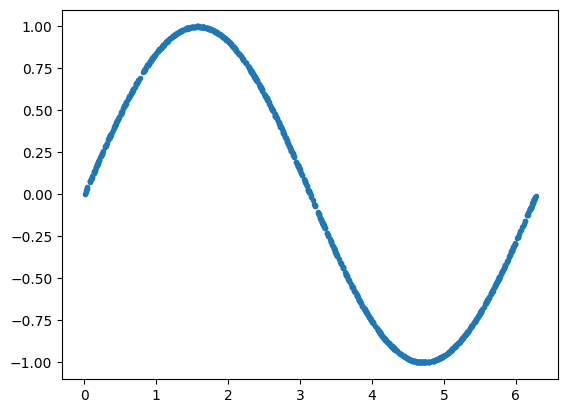

In [ ]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

plt.plot(train_data[:, 0], train_data[:, 1], ".")

#This defines the number of samples that it will return to train the network.
batch_size = 32

#This will load the data from the training set to after shuffling it.
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

#The Discriminator
Now we are going to code and create the discriminator object:, and its mission will be try to now if the data we are feeding him is from our (future) GAN or from the real database and will be a model with a two-dimensional input and a one-dimensional output.

 *Note to myself: In PyTorch, the neural network models are represented by classes that inherit from nn.Module, so you’ll have to define a class to create the discriminator.*

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

*  *nn.Dropout() is used in order to avoid overfitting*
*  *As myself may rememeber, ReLU and Sigmoid are activation functions for non-linearity*

#The Generator

In GANs, the Generator is the model that takes samples from a latent space as its input and generates data resembling the data in the training set.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

*  *Notice that it does not have the Sigmoid function at the end, as we do not want it to return a probability unlike the discriminator.*

#Training the models
Firstly, let's define the training parameters.
In this case we are using Binary Cross-Entropy function, because the task is to classify between two possibilities.

In [ ]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

Using pyTorch, we create weight upadates. In this case, using Adam's algorithm.

In [ ]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

And lastly we create a training loop making use of  the train_loader we created at the start.

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6456192135810852
Epoch: 0 Loss G.: 1.0440020561218262
Epoch: 10 Loss D.: 0.6701464653015137
Epoch: 10 Loss G.: 0.770114541053772
Epoch: 20 Loss D.: 0.6607264280319214
Epoch: 20 Loss G.: 0.7846745252609253
Epoch: 30 Loss D.: 0.7170941233634949
Epoch: 30 Loss G.: 0.7054675817489624
Epoch: 40 Loss D.: 0.6174294948577881
Epoch: 40 Loss G.: 1.0094592571258545
Epoch: 50 Loss D.: 0.5739704370498657
Epoch: 50 Loss G.: 0.915070116519928
Epoch: 60 Loss D.: 0.6580987572669983
Epoch: 60 Loss G.: 0.7299354076385498
Epoch: 70 Loss D.: 0.651013970375061
Epoch: 70 Loss G.: 0.8104874491691589
Epoch: 80 Loss D.: 0.633264422416687
Epoch: 80 Loss G.: 0.7793483734130859
Epoch: 90 Loss D.: 0.6720952987670898
Epoch: 90 Loss G.: 0.7826478481292725
Epoch: 100 Loss D.: 0.6747761964797974
Epoch: 100 Loss G.: 0.7215249538421631
Epoch: 110 Loss D.: 0.6459689140319824
Epoch: 110 Loss G.: 0.748729407787323
Epoch: 120 Loss D.: 0.7678253650665283
Epoch: 120 Loss G.: 0.8721962571144104
Epoch: 130 Lo

#Check the samples made by our GAN.





In [ ]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

And finally we plot the resulting data:

* *We are going to use .detach() to return a  tensor so that we can use it to calculate the gradients.*

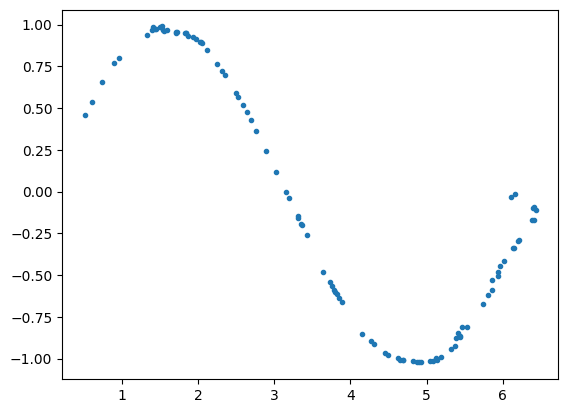

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

#GAN with images, using MNIST.

Let's import some libraries again.



In [ ]:
import torchvision
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid

To reduce the training time, you can use a GPU to train the model if you have one available. However, you’ll need to manually move tensors and models to the GPU in order to use them in the training process.

You can ensure your code will run on either setup by creating a device object that points either to the CPU or, if one is available, to the GPU:

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#Preparing the data.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

* *transforms.ToTensor() converts the data to a PyTorch tensor.*
* *transforms.Normalize() converts the range of the tensor coefficients.*

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21887667.12it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 569658.93it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2986760.36it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5571959.28it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Now we create the training set as  we did before.


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Let's plot some samples of the data.

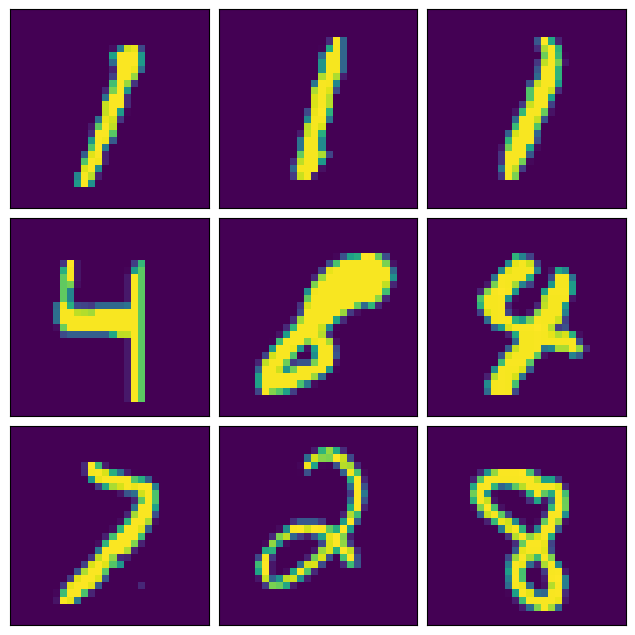

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates a 4x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, img in zip(grid, real_samples):
    ax.imshow(img.reshape(28, 28))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#Implementing the Discriminator and the Generator.

Now the network receives a vector of 784 coeficents.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to(). To use a GPU when there’s one available, you can send the model to the device object you created earlier:

In [ ]:
discriminator = Discriminator().to(device=device)

The generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

We now use the hiperbolic tangent function, as we now want the output values tobe between -1 and 1.

#Training the data

We define the training parameters, this time we will decrease the learning rate and the number of epochs.

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

The training loop this time is very similar too.

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5692472457885742
Epoch: 0 Loss G.: 0.47791537642478943
Epoch: 1 Loss D.: 0.033507682383060455
Epoch: 1 Loss G.: 4.664132595062256
Epoch: 2 Loss D.: 0.04924694448709488
Epoch: 2 Loss G.: 6.0569353103637695
Epoch: 3 Loss D.: 0.049922775477170944
Epoch: 3 Loss G.: 3.7966771125793457
Epoch: 4 Loss D.: 0.031171895563602448
Epoch: 4 Loss G.: 4.677549362182617
Epoch: 5 Loss D.: 0.044809017330408096
Epoch: 5 Loss G.: 4.837375640869141
Epoch: 6 Loss D.: 0.18939803540706635
Epoch: 6 Loss G.: 3.023841142654419
Epoch: 7 Loss D.: 0.10014118254184723
Epoch: 7 Loss G.: 4.326530456542969
Epoch: 8 Loss D.: 0.12700028717517853
Epoch: 8 Loss G.: 3.115272283554077
Epoch: 9 Loss D.: 0.3417544960975647
Epoch: 9 Loss G.: 2.1571388244628906
Epoch: 10 Loss D.: 0.31888294219970703
Epoch: 10 Loss G.: 1.8504506349563599
Epoch: 11 Loss D.: 0.30574923753738403
Epoch: 11 Loss G.: 2.0286808013916016
Epoch: 12 Loss D.: 0.3690807521343231
Epoch: 12 Loss G.: 1.5546793937683105
Epoch: 13 Loss D.: 0.52

#Checking out the produced samples.

Firstly we create some random samples and feed them to the generator, then  we plot them.


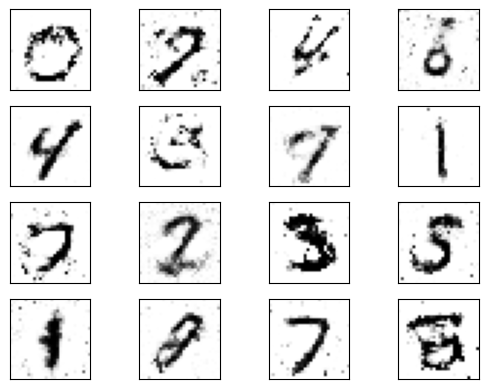

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])